<a href="https://colab.research.google.com/github/DmitryMok/MyProjects/blob/main/%D0%A6%D0%9F_%D0%9F%D1%80%D0%B8%D0%B2%D1%8F%D0%B7%D0%BA%D0%B0_%D0%B0%D1%8D%D1%80%D0%BE%D1%81%D0%BD%D0%B8%D0%BC%D0%BA%D0%BE%D0%B2_(public)%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Привязка аэроснимков к местности

Чемпионат Цифровой прорыв.

Решение Д.Мокачев

## Подключаем библиотеки

In [2]:
import cv2

import numpy as np                               # Библиотека работы с массивами
import matplotlib.pyplot as plt                  # Для отрисовки графиков
from matplotlib.path import Path

from IPython.display import Image
from google.colab.patches import cv2_imshow      # Для вывода изображений через cv2

import random                                    # Для генерации случайных чисел 
import os                                        # Для работы с файлами 
# import subprocess
# import sys

import timeit
import time 

# from shapely.geometry import Polygon            # Для функции площади многоугольника
%matplotlib inline

from math import sin, cos, pi, atan2, exp

In [13]:
# загружаю свои модули со вспомогательными функциями (использую отсюда ресайз по ширине)
!git clone https://github.com/DmitryMok/wine_helper

%cd wine_helper
from prepare_data_helper import *
%cd ..

Cloning into 'wine_helper'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 45 (delta 14), reused 33 (delta 9), pack-reused 0
Unpacking objects: 100% (45/45), done.
/content/wine_helper
/content


In [3]:
BASE_IMG_SIZE = 2294   #размер подложки после уменьшения

In [4]:
import tensorflow as tf

def seed_everything(s=42):
  # 1. The below is necessary for starting Numpy generated random numbers
  # in a well-defined initial state.
  np.random.seed(s)

  # 2. The below is necessary for starting core Python generated random numbers
  # in a well-defined state.
  random.seed(s)

  # 3. The below set_seed() will make random number generation
  # in the TensorFlow backend have a well-defined initial state.
  # For further details, see:
  # https://www.tensorflow.org/api_docs/python/tf/random/set_seed
  tf.random.set_seed(s)  

  # 4. Set the `PYTHONHASHSEED` environment variable at a fixed value
  os.environ['PYTHONHASHSEED']=str(s)

# Подготовка базы

## Скачиваем обучающий датасет

In [6]:
!wget https://lodmedia.hb.bizmrg.com/case_files/768820/train_dataset_train.zip?raw=true -O train_dataset_train.zip

--2022-07-21 09:05:31--  https://lodmedia.hb.bizmrg.com/case_files/768820/train_dataset_train.zip?raw=true
Resolving lodmedia.hb.bizmrg.com (lodmedia.hb.bizmrg.com)... 217.69.142.100
Connecting to lodmedia.hb.bizmrg.com (lodmedia.hb.bizmrg.com)|217.69.142.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1545830270 (1.4G) [application/zip]
Saving to: ‘train_dataset_train.zip’

train_dataset_train 100%[===================>]   1.44G  8.49MB/s    in 5m 24s  

2022-07-21 09:10:56 (4.55 MB/s) - ‘train_dataset_train.zip’ saved [1545830270/1545830270]



In [7]:
!unzip -q train_dataset_train.zip -d /content/train_data

## Скачиваем тестовый датасет

In [8]:
!wget https://lodmedia.hb.bizmrg.com/case_files/768820/test_dataset_test.zip?raw=true -O test_dataset_test.zip

--2022-07-21 09:11:15--  https://lodmedia.hb.bizmrg.com/case_files/768820/test_dataset_test.zip?raw=true
Resolving lodmedia.hb.bizmrg.com (lodmedia.hb.bizmrg.com)... 217.69.142.100
Connecting to lodmedia.hb.bizmrg.com (lodmedia.hb.bizmrg.com)|217.69.142.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 673951665 (643M) [application/zip]
Saving to: ‘test_dataset_test.zip’

test_dataset_test.z 100%[===================>] 642.73M  22.2MB/s    in 30s     

2022-07-21 09:11:46 (21.1 MB/s) - ‘test_dataset_test.zip’ saved [673951665/673951665]



In [9]:
!unzip -q test_dataset_test.zip -d /content/test_data

# Проверяем содержимое базы

## Загружаем подложку

In [10]:
original_image = cv2.imread('/content/train_data/original.tiff')

In [11]:
org_shape = original_image.shape
org_shape

(10496, 10496, 3)

In [16]:
# уменьшаем подложку
resized_img = resize_image(original_image, width=BASE_IMG_SIZE)
resized_img.shape

(2294, 2294, 3)

## Создаем тренировочный датасет

In [17]:
import json

In [18]:
dir_img = '/content/train_data/train/img/'
dir_json = '/content/train_data/train/json/'

# количество файлов
len(os.listdir(dir_img)), len(os.listdir(dir_json))

(800, 800)

In [19]:
# функция для получения json файла в виде словаря
def get_json(file_json='/content/annotations.json'):
  with open(file_json) as fp:
      data = json.load(fp)
  return data

In [23]:
# функция преобразует абсолютные координаты оригинального изображения в относительные координаты
def new_xy(xy):
  new_x = xy[0]/org_shape[1]
  new_y = xy[1]/org_shape[0]
  # new_x = int(xy[0]/org_shape[1]*resized_img.shape[1])
  # new_y = int(xy[1]/org_shape[0]*resized_img.shape[0])
  return [new_x, new_y]

# преобразуем угол в x и y координаты
def ang2xy(ang):
  return cos(pi/180*ang)*0.5+0.5, sin(pi/180*ang)*0.5+0.5  #нормируем угол [0:1], чтобы использовать одну функцию активации с координатами центра

In [24]:
# содержимое json и тренировочные изображения в массив
train_json_lst = os.listdir(dir_json)
train_img, train_xya = [], [] # здесь будут готовые X и Y (! X без нормализации, Y с преобразованием в a и b)
train_ang = []  # здесь будут непреобразованные углы из json
tmp_img = resized_img.copy()

for f_json in train_json_lst[:]:
  json_data = get_json(file_json=dir_json+f_json)
  coord_lst = []
  # print(f_json, json_data)
  for instance in json_data:
    # print(instance, json_data[instance])
    coord_lst.append(json_data[instance]) # массив, чтобы удобно конвертировать в др размеры
  coord_lst = np.array(coord_lst[:-1])
  # получаем координаты для отображения полигона на resized_img
  points = np.array(list(map(new_xy,coord_lst)))
  # print(coord_lst, points)
  points[[2,3]] = points[[3,2]]
  tmp_img = cv2.polylines(tmp_img, np.int32([points*resized_img.shape[0]]), 1, (255,255,255),3)

  # координаты центра
  xy_center = (np.max(points, axis=0) + np.min(points, axis=0))/2
  # формируем массив из x/y центра и x/y угла нормированного [-1:1]
  train_xya.append(np.concatenate([xy_center, ang2xy(json_data[instance])]))
  # загружаем соответствующий фрагмент для добавления в тренировочную базу в размере 224
  train_frag = resize_image(cv2.imread(dir_img+change_file_ext(f_json,'png')),width=224)
  train_img.append(train_frag)
  train_ang.append(json_data[instance])
  
train_xya = np.array(train_xya)
train_img = np.array(train_img)

In [25]:
train_img.shape, train_xya.shape

((800, 224, 224, 3), (800, 4))

In [26]:
# список файлов с изображениями для обращения по индексу
train_img_lst = list(map(lambda x:change_file_ext(x,'png'),train_json_lst))

In [27]:
train_img_lst[:5], train_json_lst[:5]

(['690.png', '507.png', '584.png', '538.png', '61.png'],
 ['690.json', '507.json', '584.json', '538.json', '61.json'])

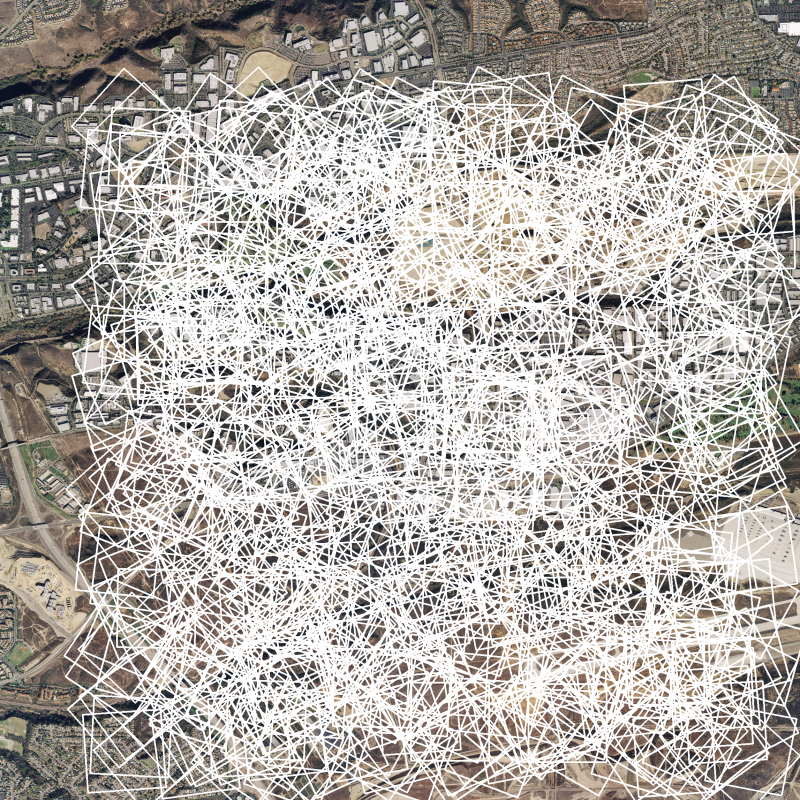

In [28]:
# все тренировочные фрагменты
cv2_imshow(resize_image(tmp_img, width=800))

# Обучаем Нейронную сеть

In [30]:
frag_height = 224 # Высота 
frag_width = 224 # Ширина 

chanels = 3 # Количество каналов  

input_frag_shape = (frag_height, frag_width, chanels)  # на этот вход подаем фрагмент

In [32]:
from tensorflow.keras.applications import VGG16, InceptionResNetV2, EfficientNetB5, EfficientNetB6, ResNet50, ResNet152, ResNet50V2 
# для создания сети
from tensorflow.keras.models import Sequential, Model

# для создания слоев
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, SpatialDropout2D, RandomRotation
from tensorflow.keras.layers import Input, concatenate, GlobalAveragePooling2D, Softmax, ReLU, GlobalMaxPooling2D
from tensorflow.keras.layers import Resizing, Concatenate, Reshape, AveragePooling2D


# для работы с изображениями
from tensorflow.keras.preprocessing import image

from tensorflow.keras.metrics import binary_accuracy, CategoricalAccuracy 

from tensorflow.keras.losses import BinaryCrossentropy, binary_crossentropy, categorical_crossentropy, CosineSimilarity

# оптимизатор
from tensorflow.keras.optimizers import Adam, SGD

from tensorflow.keras.callbacks import LambdaCallback, EarlyStopping, Callback, LearningRateScheduler, ModelCheckpoint

from tensorflow.keras.applications.resnet_v2 import preprocess_input

# модуль для отсчета времени
import time 
# import datetime

import matplotlib.pyplot as plt

from tensorflow.keras import backend as K

In [33]:
input_frag = Input(shape=input_frag_shape)

base_model = EfficientNetB6(weights="imagenet", pooling='avg', include_top=False, input_tensor=input_frag)(input_frag)

165249024/165234480 [==============================] - 1s 0us/step


In [34]:
def create_back(base_model, act = "sigmoid", d1 = 256, d2 = 512, d3 = 128):
  back = Dense(d1, activation="relu", name="back1")(base_model)
  # back = Flatten()(back)
  if d2: back = Dense(d2, activation="relu", name="back2")(back)  
  if d3: back = Dense(d3, activation="relu", name="back3")(back)  
  output = (Dense(4, activation=act, name="output")(back))  
  return output

In [35]:
# seed_everything(42)
model = Model(input_frag, create_back(base_model, act = "linear", d1 = 256, d2 = 512, d3 = 128)) # 

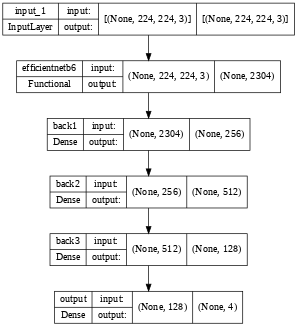

In [36]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True,dpi=50, show_layer_names=True)

In [38]:
def scheduler(epoch, lr):
   if epoch < 9:
     return lr
   else:
     return lr * exp(-0.1)

callback = LearningRateScheduler(scheduler)

In [ ]:
hist = [[],[],[],[]]  # запись истории

for i in range(1):
  print('Обучаем модель: EfficientNetB6')
  seed_everything(42)
  model.compile(loss='mse',
                optimizer=Adam(learning_rate=1e-3),
                metrics=['mae'])

  store = model.fit(train_img[:], train_xya[:],
                  epochs = 20,
                  batch_size = 10,
                  verbose = 1,
                  # validation_data = (x_val, y_val),
                  # validation_data = (train_img[600:], train_xya[600:]),
                  callbacks=[callback]
                  )
  
###########################

  # hist[0].extend(store.history['compute_metric_simp'])
  # hist[1].extend(store.history['val_compute_metric_simp'])
  hist[2].extend(store.history['loss'])
  hist[3].extend(store.history['val_loss'])

  # plt.plot(hist[0], label='Обучающая')
  # plt.plot(hist[1], label='Проверочная')
  # plt.legend()
  # plt.title('Точность')
  # plt.show()
  plt.plot(hist[2], label='Обучающая')
  plt.plot(hist[3], label='Проверочная')
  plt.legend()
  plt.title('Ошибка')
  plt.show()

Обучаем модель: EfficientNetB6
Epoch 1/20
80/80 [==============================] - 54s 427ms/step - loss: 0.0443 - mae: 0.1609 - lr: 0.0010
Epoch 2/20
80/80 [==============================] - 35s 432ms/step - loss: 0.0287 - mae: 0.1309 - lr: 0.0010
Epoch 3/20
80/80 [==============================] - 35s 434ms/step - loss: 0.0240 - mae: 0.1160 - lr: 0.0010
Epoch 4/20
80/80 [==============================] - 35s 431ms/step - loss: 0.0162 - mae: 0.0968 - lr: 0.0010
Epoch 5/20
80/80 [==============================] - 35s 433ms/step - loss: 0.0135 - mae: 0.0897 - lr: 0.0010
Epoch 6/20
80/80 [==============================] - 35s 435ms/step - loss: 0.0133 - mae: 0.0883 - lr: 0.0010
Epoch 7/20
80/80 [==============================] - 35s 432ms/step - loss: 0.0151 - mae: 0.0934 - lr: 0.0010
Epoch 8/20
80/80 [==============================] - 35s 432ms/step - loss: 0.0193 - mae: 0.1042 - lr: 0.0010
Epoch 9/20
80/80 [==============================] - 35s 432ms/step - loss: 0.0211 - mae: 0.1081 -

KeyError: ignored

Обучаем модель: EfficientNetB6
Epoch 1/20
80/80 [==============================] - 40s 429ms/step - loss: 5.8672e-04 - mae: 0.0186 - lr: 4.9916e-06
Epoch 2/20
80/80 [==============================] - 35s 435ms/step - loss: 5.7184e-04 - mae: 0.0185 - lr: 4.9916e-06
Epoch 3/20
80/80 [==============================] - 34s 431ms/step - loss: 5.6154e-04 - mae: 0.0183 - lr: 4.9916e-06
Epoch 4/20
80/80 [==============================] - 34s 429ms/step - loss: 5.2161e-04 - mae: 0.0178 - lr: 4.9916e-06
Epoch 5/20
80/80 [==============================] - 35s 433ms/step - loss: 4.9281e-04 - mae: 0.0172 - lr: 4.9916e-06
Epoch 6/20
80/80 [==============================] - 35s 432ms/step - loss: 4.8276e-04 - mae: 0.0170 - lr: 4.9916e-06
Epoch 7/20
80/80 [==============================] - 35s 432ms/step - loss: 4.9699e-04 - mae: 0.0173 - lr: 4.9916e-06
Epoch 8/20
80/80 [==============================] - 34s 430ms/step - loss: 4.8893e-04 - mae: 0.0171 - lr: 4.9916e-06
Epoch 9/20
80/80 [===============

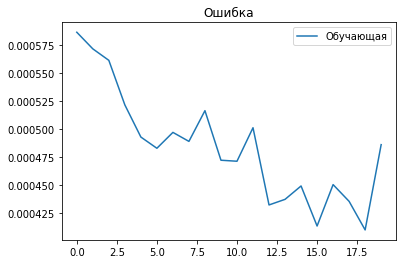

Обучаем модель: EfficientNetB6
Epoch 1/20
80/80 [==============================] - 43s 438ms/step - loss: 5.4272e-04 - mae: 0.0179 - lr: 1.6616e-06
Epoch 2/20
80/80 [==============================] - 35s 434ms/step - loss: 5.2753e-04 - mae: 0.0178 - lr: 1.6616e-06
Epoch 3/20
80/80 [==============================] - 35s 431ms/step - loss: 5.1994e-04 - mae: 0.0176 - lr: 1.6616e-06
Epoch 4/20
80/80 [==============================] - 35s 433ms/step - loss: 4.8289e-04 - mae: 0.0171 - lr: 1.6616e-06
Epoch 5/20
80/80 [==============================] - 35s 433ms/step - loss: 4.5214e-04 - mae: 0.0164 - lr: 1.6616e-06
Epoch 6/20
80/80 [==============================] - 34s 431ms/step - loss: 4.4442e-04 - mae: 0.0163 - lr: 1.6616e-06
Epoch 7/20
80/80 [==============================] - 35s 434ms/step - loss: 4.5780e-04 - mae: 0.0166 - lr: 1.6616e-06
Epoch 8/20
80/80 [==============================] - 34s 431ms/step - loss: 4.4883e-04 - mae: 0.0164 - lr: 1.6616e-06
Epoch 9/20
80/80 [===============

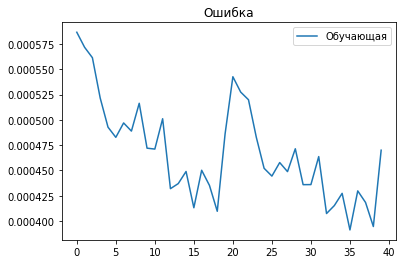

Executed


In [ ]:
# дообучение
hist = [[],[],[],[]]  # запись истории

for i in range(2):
  print('Обучаем модель: EfficientNetB6')

  store = model.fit(train_img[:], train_xya[:],
                  epochs = 2,
                  batch_size = 10,
                  verbose = 1,
                  # validation_data = (x_val, y_val),
                  # validation_data = (train_img[600:], train_xya[600:]),
                  callbacks=[callback]
                  )
  
  model.save('/content/drive/MyDrive/Aerophoto/weights/3/')

  # hist[0].extend(store.history['compute_metric_simp'])
  # hist[1].extend(store.history['val_compute_metric_simp'])
  hist[2].extend(store.history['loss'])
  # hist[3].extend(store.history['val_loss'])

  # plt.plot(hist[0], label='Обучающая')
  # plt.plot(hist[1], label='Проверочная')
  # plt.legend()
  # plt.title('Точность')
  # plt.show()
  plt.plot(hist[2], label='Обучающая')
  # plt.plot(hist[3], label='Проверочная')
  plt.legend()
  plt.title('Ошибка')
  plt.show()

try:
  sound()
  print('Executed')
except:
  print('Executed')

# Готовим json с результатами

In [42]:
# при необходимости загружаем обученные веса
# https://drive.google.com/drive/folders/14cY9EpLXZp77mOoVy0RnySNoA9mTFwz8?usp=sharing
model.load_weights('/content/weights/')

In [46]:
# преобразуем x и y координаты в угол
def xy2ang(xa,ya):
  a_cos, a_sin = (xa-0.5)*2, (ya-0.5)*2
  angle = np.arctan2(a_sin,a_cos)*180/pi
  if angle < 0: angle += 360
  return angle  #угол в градусах

In [49]:
# расчет метрики
def compute_metric_simp(data_true, data_pred, outImageW = org_shape[1], outImageH = org_shape[0]):

  x_center_true = data_true[0]
  y_center_true = data_true[1]

  x_metr = x_center_true - data_pred[0]
  y_metr = y_center_true - data_pred[1] 

  angle_true = xy2ang(data_true[2], data_true[3])
  angle_pred = xy2ang(data_pred[2], data_pred[3])

  # print('x_metr, y_metr:', x_metr, y_metr, '\nangle_true, angle_pred:', angle_true, angle_pred)
  # print()

  metr =  1- (0.7 * 0.5 * (abs(x_metr) + abs(y_metr)) + 0.3 *min(abs(angle_true - angle_pred), abs(abs(angle_true - angle_pred)-360))/360)
  return metr

compute_metric_simp(train_xya[0], train_xya[0]), compute_metric_simp(train_xya[0], train_xya[1])

(1.0, 0.6849657012195123)

In [50]:
# Загружаем данные
dir_test_img = '/content/test_data/'
test_img_lst = os.listdir(dir_test_img)

# количество файлов
print(len(os.listdir(dir_test_img)))

test_img = [] # здесь будут тестовые изображения в нужном размере (224)
# tmp_img = resized_img.copy()

for f_img in test_img_lst[:]:
  # загружаем соответствующий фрагмент для добавления в тренировочную базу в размере 224
  test_frag = resize_image(cv2.imread(dir_test_img+f_img),width=224)
  test_img.append(test_frag)
  
test_img = np.array(test_img)

400


In [51]:
# предсказываем координаты на тестовой выборке
p = model.predict(test_img)

### Конвертируем в json

In [54]:
def convert2json(xya):
  # print(xya)

  # 1. находим координаты углов и расчитываем угол
  points = get_points(xya, img_shape=org_shape)
  angle = xy2ang(*xya[2:])

  # print(points, angle, '\ncenter:', xya[:2]*org_shape[0])


  # 2. Создаем словарь, который запишем в json файл
  result_json = {}
  result_json["left_top"] = list(map(int,points[2])) #
  result_json["right_top"] = list(map(int,points[1])) #
  result_json["left_bottom"] = list(map(int,points[0])) #
  result_json["right_bottom"] = list(map(int,points[3])) #
  result_json["angle"] = int(angle) #

  return result_json

#{"left_top": [1098, 6721], "right_top": [2116, 6828], "left_bottom": [991, 7739], "right_bottom": [2009, 7846], "angle": 6}

# json_data = convert2json(test_data)

In [59]:
# функция преобразует координаты центра и поворот в коордитаты углов LT RT LB RB 
def M(angle):
  # угол от градуса до радиана
  angle = np.radians(angle)
  # матрица преобразования для вращения
  M = np.float32([ [np.cos(angle), -(np.sin(angle)), 0],
                [np.sin(angle), np.cos(angle), 0],
                [0, 0, 1] ])
  return M

def get_points(xya, img_shape=(640,640,3)):
  # переводим из нормализации в cos и sin угла
  point = np.float32([(xya[2]-0.5)*2,(xya[3]-0.5)*2,1])
  # print(point)

  # абсолютные координаты центра
  x_center = int(xya[0]*img_shape[1])
  y_center = int(xya[1]*img_shape[0])

  new_xy = (M(135) @ point) # left top
  x1, y1 = new_xy[0], new_xy[1]

  new_xy = (M(45) @ point) # left top
  x2, y2 = new_xy[0], new_xy[1]

  new_xy = (M(-135) @ point) # left top
  x3, y3 = new_xy[0], new_xy[1]

  new_xy = (M(-45) @ point) # left top
  x4, y4 = new_xy[0], new_xy[1]

  angle = atan2(xya[3],xya[2])

  points = np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])*frag_width/2/resized_img.shape[0]*img_shape[0]
  # смещение на координаты центра
  points[:,0] += x_center
  points[:,1] += y_center
  # print(x_center)

  return points

### Сохраняем json

In [ ]:
json_result_dir = '/content/json_results/'

def json_save(json_data, fname):
  with open(json_result_dir+fname, 'w') as f:
      json.dump(json_data, f)

In [60]:
for i, f_name in enumerate(test_img_lst[:]):
  json_data = convert2json(p[i])  #
  fname = change_file_ext(f_name, ext='json')
  # print(fname, json_data)
  # json_save(json_data, fname)

In [63]:
print('Содержимое файла', fname, '\n', json_data)

Содержимое файла 678.json 
 {'left_top': [8430, 6251], 'right_top': [9137, 5532], 'left_bottom': [9143, 6245], 'right_bottom': [8424, 5538], 'angle': 269}
